# ConvNet-LSTM Sentiment Classifier

Classifying IMDB reviews by their sentiment with an *Convolutional-Bidirectional LSTM Stack*.

#### Load dependencies 

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, SpatialDropout1D, LSTM
from keras.layers.wrappers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\siddh\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set Hyperparameter 

In [2]:
output_dir = './model_output/cnnLSTM'

epochs = 4
batch_size = 128

n_dim = 64
n_unique_words = 10000
max_review_length = 200
pad_type = trunc_type = 'pre'
drop_embed = 0.2

n_conv = 64
k_conv = 3

mp_size = 4

n_lstm = 64
dropout_lstm = 0.2

#### Load data 

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Preprocess data 

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design NN Architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv,activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm, dropout=dropout_lstm)))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 718,529
Trainable params: 718,529
Non-trainable params: 0
_________________________________________________________________


#### configure model 

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train! 

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 64s 3ms/step - loss: 0.4529 - acc: 0.7621 - val_loss: 0.3154 - val_acc: 0.8706
Epoch 2/4
25000/25000 [==============================] - 51s 2ms/step - loss: 0.2432 - acc: 0.9025 - val_loss: 0.3281 - val_acc: 0.8708
Epoch 3/4
25000/25000 [==============================] - 44s 2ms/step - loss: 0.1733 - acc: 0.9356 - val_loss: 0.3310 - val_acc: 0.8586
Epoch 4/4
25000/25000 [==============================] - 46s 2ms/step - loss: 0.1303 - acc: 0.9527 - val_loss: 0.3425 - val_acc: 0.8538


#### Evaluate 

In [10]:
model.load_weights(output_dir+'/weights.01.hdf5')

In [11]:
y_hat = model.predict_proba(x_valid)

In [12]:
y_hat[0]

array([0.04329116], dtype=float32)

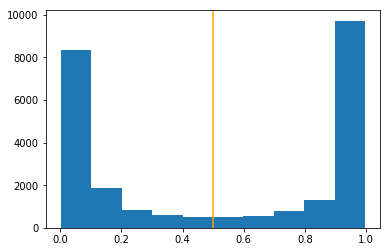

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [15]:
"{:0.2f}".format(pct_auc)

'94.49'